# ZMAP

This file creates a zmap, only from top, not sides.

Steps:

- Get the mask of the image using dottamine. The mask is viewed from side (mask_r). Times is usually 3 and binshape is 2, 2, 2.
- Now we do 2D morphology close using cv2 package on the mask_r with np.ones 10,10. And extract the top, left and right line. It is just the first mask pixel that appears viewed from top, left and right. We sum all of them to have a more complete line.
- Once we have the sum mask we look it from top and start doing hull (skimage package). That will help to estimate where the non-detected cells in the dome are.
- After getting the hull mask we extract the top of this hull mask.
- We do gaussian filter and epithelial process for both:
    - Hull line
    - Sum line 
- We use a more complex function to get the countour of cells using both hull and sum lines. This will result in a first approximation that is able to find dark cells and cells that are in corners (that hull would not detect at all).
- Using this first line we generate another gaussian and epithelial to then use a simpler falling line function. This will be the final result of the dome surface.

In [3]:
import skimage as sk
import matplotlib.pyplot as plt
from dottamine import dotim
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, rotate
import tifffile as tiff
import multiprocessing

In [4]:
def normalize_image(im, mult_factor = 1):
    '''
    Normalize image (any Dimensions) function.
    '''
    im = np.array(im)
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

def reverse_values(im):
    rev_im = im.max()-im
    return rev_im

def first_nonzero(d3_array, axis=0, moveLine=0):
    '''
    Get a line from a mask (3d array). 
    - axis can be 0, 1, 2. 
    - moveLine is the amount of pixels you want to move the line up or down.
    '''

    first_nonzero_indices = np.argmax(d3_array != 0, axis=axis)

    ## Move up or down the line
    first_nonzero_indices = first_nonzero_indices+moveLine # Units to move the line. If > 0  the line will be lower, useful to get the basal? If < 0 the line will be higher, useful for apical.
    first_nonzero_indices[first_nonzero_indices < 0] = 0
    first_nonzero_indices[first_nonzero_indices >= d3_array.shape[1]] = d3_array.shape[1]-1
    ## Fi move up or down the line

    top_mask_r = np.zeros_like(d3_array)
    top_mask_r[np.arange(d3_array.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(d3_array.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask
    if axis==0:
        top_mask_r[0,:,:] = 0
    if axis==1:
        top_mask_r[:,0,:] = 0
    if axis==2:
        top_mask_r[:,:,0] = 0

    return top_mask_r

def get_image_r(image):
    image_r = np.transpose(image, axes=(1,0,2))
    image_r = np.transpose(image_r, axes=(2, 1, 0)) # Image from side front

    return image_r

In [5]:
time_dome = str(4)
# image = sk.io.imread('./../ppujol/zmap/62_denoised time '+time_dome+'.tif') # Image from top
folder_and_dome = str('./../../../Desktop/dome70_fallinglineMove/70_denoised_tp')
image = sk.io.imread(folder_and_dome+time_dome+'.tif') # Image from top

image_r = get_image_r(image)

: 

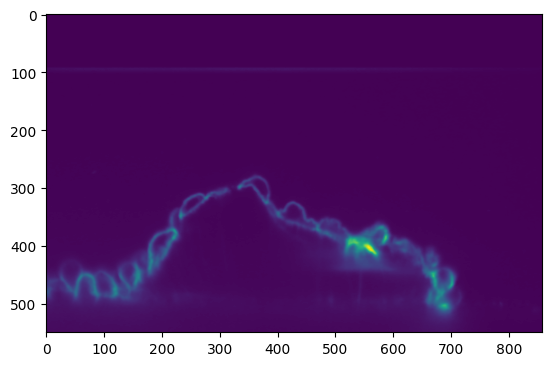

In [5]:
plt.imshow(image_r[300])

In [13]:
doter = dotim(image_r, is2D=False, treat_3D_as_2D=False) #### image or image_r
mask_r = doter.get_mask(times=3, binshape=(2,2,2), v='+') # Get the mask from side front
mask_r = mask_r.astype(np.uint16) # Make the mask uint16

# #### comment this if the image fed to doter is not from top!!!
# mask_r = np.transpose(mask_r, axes=(1,0,2))
# mask_r = np.transpose(mask_r, axes=(2, 1, 0)) # Image from side front
# #### comment this if the image fed to doter is not from top!!!


Convolving: 1/3
Convolving: 2/3
Convolving: 3/3
Deconvolving: 3/3
Deconvolving: 2/3
Deconvolving: 1/3


In [6]:
# tiff.imwrite(folder_and_dome+time_dome+'_mask.tif', normalize_image(mask_r, 1).astype(np.uint16), imagej=True)
mask_r = sk.io.imread(folder_and_dome+time_dome+'_mask.tif')

In [7]:
closed_mask_r = []
for i in mask_r:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((10, 10)))
    closed_mask_r.append(full)

closed_mask = np.array(closed_mask_r) # Mask once closed

## Find the top line of the mask
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
top_mask = np.zeros_like(closed_mask) # Line from top
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask

## Find the left line of the mask
first_left_nonzero_indices = np.argmax(closed_mask != 0, axis=2)
left_mask = np.zeros_like(closed_mask) # Line from left
left_mask[np.arange(closed_mask.shape[0])[:, None, None], np.arange(closed_mask.shape[1]), first_left_nonzero_indices[None, :, None]] = 1 # Top mask is a 3D array that contains the left line of the actual mask

## Find the right line of the mask
last_right_nonzero_indices = closed_mask.shape[2] - np.argmax(closed_mask[:, :, ::-1] != 0, axis=2) - 1
right_mask = np.zeros_like(closed_mask) # Line from right
right_mask[np.arange(closed_mask.shape[0])[:, None, None], np.arange(closed_mask.shape[1]), last_right_nonzero_indices[None, :, None]] = 1 # Right mask is a 3D array that contains the right line of the actual mask

sum_mask = top_mask+left_mask+right_mask # Sum of lines from top
# Make the first and last for each axis 0.
sum_mask[0, :, :] = 0
sum_mask[-1, :, :] = 0
sum_mask[:, 0, :] = 0
sum_mask[:, -1, :] = 0
sum_mask[:, :, 0] = 0
sum_mask[:, :, -1] = 0

sum_mask = np.transpose(sum_mask, axes=(1,2,0)) # Sum viewed from top

sum_mask_r = get_image_r(sum_mask)

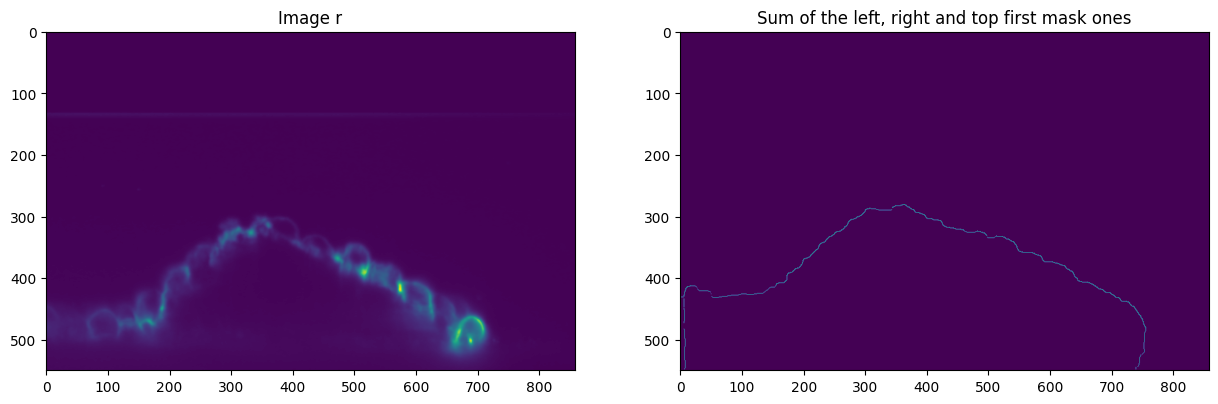

In [8]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('Image r')
plt.imshow(image_r[260])
plt.subplot(122)
plt.title('Sum of the left, right and top first mask ones')
plt.imshow(sum_mask_r[260])

In [9]:
def get_hull_from_top(i, num, return_dict):
    hull_i = sk.morphology.convex_hull_image(i)
    return_dict[num] = hull_i


manager=multiprocessing.Manager()
return_dict = manager.dict()
jobs = []

for i, num in zip(sum_mask, range(sum_mask.shape[0])):
    p = multiprocessing.Process(target=get_hull_from_top, args=(i, num, return_dict))
    jobs.append(p)
    p.start()

for proc in jobs:
    proc.join()
hull = [return_dict[idx] for idx in sorted(return_dict.keys())]


hull = np.array(hull) # Hull is a closed volume that should contain all the cells or pass through them. View top
hull = hull.astype(np.uint8)

hull_r = get_image_r(hull)

##### MOVE LINE ON!!!! #####
moveLine=0
hull_top_line_r = first_nonzero(hull_r, axis=1, moveLine=moveLine) # This is the top line of hull_r
hull_top_line = np.transpose(hull_top_line_r, axes=(1,2,0)) # This is the top hull line viewed from top

/tmp/ipykernel_1401065/1926138075.py:2: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  hull_i = sk.morphology.convex_hull_image(i)
/tmp/ipykernel_1401065/1926138075.py:2: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  hull_i = sk.morphology.convex_hull_image(i)
/tmp/ipykernel_1401065/1926138075.py:2: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  hull_i = sk.morphology.convex_hull_image(i)
/tmp/ipykernel_1401065/1926138075.py:2: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  hull_i = sk.morphology.convex_hull_image(i)
/tmp/ipykernel_1401065/1926138075.py:2: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  hull_i = sk.morphology.convex_hull_image(i)
/tmp/ipykernel_1401065/1926138075.py:2: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  hull_i

In [10]:
hull_top_line = hull_top_line.astype(np.float64)
gaussian_hull_top_line = gaussian_filter(hull_top_line, 20)
gaussian_hull_top_line = normalize_image(gaussian_hull_top_line)
epithelial_hull = gaussian_hull_top_line*image # The gaussian cells viewed from top obtained using hull

sum_mask = sum_mask.astype(np.float64)
gaussian_sum_mask = gaussian_filter(sum_mask, 20)
gaussian_sum_mask = normalize_image(gaussian_sum_mask)
epithelial_sum = gaussian_sum_mask*image  # The gaussian cells viewed from top obtained using sum lines


epithelial_hull_r = get_image_r(epithelial_hull)
gaussian_hull_top_line_r = get_image_r(gaussian_hull_top_line)
epithelial_sum_r = get_image_r(epithelial_sum)
gaussian_sum_mask_r = get_image_r(gaussian_sum_mask)

In [11]:
def shape_finder_2D(epithelial, angle=40):
    '''
    Falling line algorithm for 2D front image rotation, delta degree = 20º
    - epithelial is the 2D image that has to be fed from front
    - angle is the max rotation for the 2D image
    '''

    angles = [i for i in range(-angle, angle+1, 20)]
    # angles = [-40]
    total_cell_mask = np.zeros(shape=(epithelial.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_height_mask = rotate(epithelial, angle, reshape=False) # Be careful of the reshape=False
        ## Find the border of the cell which is the maximum of this masked image.
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_height_mask.shape[1]):
            col = rot_height_mask[:, i]
            max_pos = np.argmax(col == max(col))

            if max_pos <= len(col)*0.95 and max_pos >= len(col)*0.05 and max(col) >= col.mean()+2*col.std(): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos) # Search for the first max
            else:
                cell_border.append('-')

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_height_mask)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        horizontal_cut = 4
        cell_top_mask_rot[:, :horizontal_cut] = 0
        cell_top_mask_rot[:, -horizontal_cut:] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)



def shape_finder_2D_multiprocessing(epithelial, num, return_dict, angle=40):
    '''
    Falling line algorithm for 2D front image rotation, delta degree = 20º
    - epithelial is the 2D image that has to be fed from front
    - angle is the max rotation for the 2D image
    '''

    angles = [i for i in range(-angle, angle+1, 20)]
    # angles = [-40]
    total_cell_mask = np.zeros(shape=(epithelial.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_height_mask = rotate(epithelial, angle, reshape=False) # Be careful of the reshape=False
        ## Find the border of the cell which is the maximum of this masked image.
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_height_mask.shape[1]):
            col = rot_height_mask[:, i]
            max_pos = np.argmax(col == max(col))

            if max_pos <= len(col)*0.95 and max_pos >= len(col)*0.05 and max(col) >= col.mean()+2*col.std(): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos) # Search for the first max
            else:
                cell_border.append('-')

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_height_mask)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        horizontal_cut = 4
        cell_top_mask_rot[:, :horizontal_cut] = 0
        cell_top_mask_rot[:, -horizontal_cut:] = 0
        total_cell_mask += cell_top_mask_rot

    return_dict[num] = np.array(total_cell_mask)




def shape_finder_2D_v2(hull_lines, hull_mask, sum_lines, sum_mask, angle=40):
    '''
    Get the first approximation using hull and sum lines, delta degree = 20º
    - hull_lines is the epithelial obtained from hull mask
    - hull_mask is the gaussian or the line obtained using hull from front
    - sum_lines is the epithelial obtained from sum mask
    - sum_mask is the gaussian or the line obtained using hull from front
    - angle is the max rotation for the 2D image
    '''
    angles = [i for i in range(-angle, angle+1, 20)]
    # angles = [40]
    total_cell_mask = np.zeros(shape=(hull_lines.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_hull_lines = rotate(hull_lines, angle, reshape=False) # Be careful of the reshape=False
        rot_hull_mask = rotate(hull_mask, angle, reshape=False)
        rot_sum_lines = rotate(sum_lines, angle, reshape=False)
        rot_sum_mask = rotate(sum_mask, angle, reshape=False)
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_hull_lines.shape[1]):
            col_hull_lines = rot_hull_lines[:, i]
            max_pos_hull_lines = np.argmax(col_hull_lines == max(col_hull_lines))
            col_hull_mask = rot_hull_mask[:, i]
            max_pos_hull_mask = np.argmax(col_hull_mask == max(col_hull_mask))

            col_sum_lines = rot_sum_lines[:, i]
            max_pos_sum_lines = np.argmax(col_sum_lines == max(col_sum_lines))
            col_sum_mask = rot_sum_mask[:, i]
            max_pos_sum_mask = np.argmax(col_sum_mask == max(col_sum_mask))

            # print(max_pos_hull_lines, max_pos_hull_mask, abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask)


            #   Check that the position is lower than the col ------ Check that the position is grater than the bottom -- 
            if ((max_pos_hull_lines <= len(col_hull_lines)*0.90) and (max_pos_hull_lines >= len(col_hull_lines)*0.1) and 
                # Check that the column has some variation 3 is super conservative ------- Check the distance to the original line
                (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos_hull_lines) # Search for the first max

            #   Check that the position is lower than the col ------ Check that the position is grater than the bottom -- 
            elif ((max_pos_sum_lines <= len(col_sum_lines)*0.90) and (max_pos_sum_lines >= len(col_sum_lines)*0.1) and 
                # Check that the column has some variation 3 is super conservative ------- Check the distance to the original line
                (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (abs(max_pos_sum_lines-max_pos_sum_mask)/max_pos_sum_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos_sum_lines) # Search for the first max

            else:
                cell_border.append('-')
                # cell_border.append(max_pos_sum_lines) 

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_hull_lines)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        horizontal_cut = 4
        cell_top_mask_rot[:, :horizontal_cut] = 0
        cell_top_mask_rot[:, -horizontal_cut:] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)



def shape_finder_2D_v2_multiprocessing(hull_lines, hull_mask, sum_lines, sum_mask, num, return_dict, angle=40):
    '''
    Get the first approximation using hull and sum lines, delta degree = 20º
    - hull_lines is the epithelial obtained from hull mask
    - hull_mask is the gaussian or the line obtained using hull from front
    - sum_lines is the epithelial obtained from sum mask
    - sum_mask is the gaussian or the line obtained using hull from front
    - angle is the max rotation for the 2D image
    '''
    angles = [i for i in range(-angle, angle+1, 20)]
    # angles = [40]
    total_cell_mask = np.zeros(shape=(hull_lines.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_hull_lines = rotate(hull_lines, angle, reshape=False) # Be careful of the reshape=False
        rot_hull_mask = rotate(hull_mask, angle, reshape=False)
        rot_sum_lines = rotate(sum_lines, angle, reshape=False)
        rot_sum_mask = rotate(sum_mask, angle, reshape=False)
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_hull_lines.shape[1]):
            col_hull_lines = rot_hull_lines[:, i]
            max_pos_hull_lines = np.argmax(col_hull_lines == max(col_hull_lines))
            col_hull_mask = rot_hull_mask[:, i]
            max_pos_hull_mask = np.argmax(col_hull_mask == max(col_hull_mask))

            col_sum_lines = rot_sum_lines[:, i]
            max_pos_sum_lines = np.argmax(col_sum_lines == max(col_sum_lines))
            col_sum_mask = rot_sum_mask[:, i]
            max_pos_sum_mask = np.argmax(col_sum_mask == max(col_sum_mask))

            # print(max_pos_hull_lines, max_pos_hull_mask, abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask)


            #   Check that the position is lower than the col ------ Check that the position is grater than the bottom -- 
            if ((max_pos_hull_lines <= len(col_hull_lines)*0.90) and (max_pos_hull_lines >= len(col_hull_lines)*0.1) and 
                # Check that the column has some variation 3 is super conservative ------- Check the distance to the original line
                (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos_hull_lines) # Search for the first max

            #   Check that the position is lower than the col ------ Check that the position is grater than the bottom -- 
            elif ((max_pos_sum_lines <= len(col_sum_lines)*0.90) and (max_pos_sum_lines >= len(col_sum_lines)*0.1) and 
                # Check that the column has some variation 3 is super conservative ------- Check the distance to the original line
                (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (abs(max_pos_sum_lines-max_pos_sum_mask)/max_pos_sum_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos_sum_lines) # Search for the first max

            else:
                cell_border.append('-')
                # cell_border.append(max_pos_sum_lines) 

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_hull_lines)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        horizontal_cut = 4
        cell_top_mask_rot[:, :horizontal_cut] = 0
        cell_top_mask_rot[:, -horizontal_cut:] = 0
        total_cell_mask += cell_top_mask_rot

    return_dict[num] = np.array(total_cell_mask)

In [12]:
import sys
import gc

def get_variable_sizes():
    # Get local variable names and their sizes
    local_vars = {var: sys.getsizeof(eval(var)) for var in list(locals().keys())}
    
    # Get global variable names and their sizes
    global_vars = {var: sys.getsizeof(eval(var)) for var in list(globals().keys())}
    
    # Combine local and global variable names and sizes
    all_vars = {**local_vars, **global_vars}
    
    # Sort variables by size
    sorted_vars = dict(sorted(all_vars.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_vars

# Your code here

# Get variable names and sizes after your code
variable_sizes = get_variable_sizes()

# Print variable names and sizes
for var, size in variable_sizes.items():
    print(f"{var}: {size} bytes")

del mask_r, closed_mask, top_mask, left_mask, right_mask, first_nonzero_indices, first_left_nonzero_indices, last_right_nonzero_indices, epithelial_hull, hull, hull_r, hull_top_line, epithelial_sum, sum_mask, gaussian_sum_mask, gaussian_hull_top_line
gc.collect()  # Force garbage collection to free up memory

sum_mask: 3239121744 bytes
hull_top_line: 3239121744 bytes
gaussian_hull_top_line: 3239121744 bytes
epithelial_hull: 3239121744 bytes
gaussian_sum_mask: 3239121744 bytes
epithelial_sum: 3239121744 bytes
mask_r: 809780544 bytes
closed_mask: 809780544 bytes
top_mask: 809780544 bytes
left_mask: 809780544 bytes
right_mask: 809780544 bytes
hull: 404890344 bytes
hull_top_line_r: 404890344 bytes
first_nonzero_indices: 5889440 bytes
first_left_nonzero_indices: 3775328 bytes
last_right_nonzero_indices: 3775328 bytes
full: 943928 bytes
_i: 22976 bytes
_i11: 22976 bytes
closed_mask_r: 6936 bytes
jobs: 4792 bytes
_i7: 1717 bytes
_i2: 1586 bytes
_i3: 1586 bytes
_i12: 1143 bytes
dotim: 1072 bytes
_iii: 936 bytes
_i9: 936 bytes
_ii: 789 bytes
_i10: 789 bytes
_i4: 346 bytes
_i1: 256 bytes
_i8: 243 bytes
_oh: 232 bytes
Out: 232 bytes
_i6: 222 bytes
_ih: 184 bytes
In: 184 bytes
__vsc_ipynb_file__: 154 bytes
open: 144 bytes
gaussian_filter: 144 bytes
rotate: 144 bytes
normalize_image: 144 bytes
reverse_v

30

In [13]:
manager = multiprocessing.Manager()
return_dict = manager.dict()
jobs = []

for i, j, k, l, num in zip(normalize_image(epithelial_hull_r), normalize_image(hull_top_line_r), normalize_image(epithelial_sum_r), normalize_image(sum_mask_r), range(epithelial_hull_r.shape[0])):
    p = multiprocessing.Process(target=shape_finder_2D_v2_multiprocessing, args=(i, j, k, l, num, return_dict))
    jobs.append(p)
    p.start()

for proc in jobs:
    proc.join()

apical_dots_1_r = np.array([return_dict[idx] for idx in sorted(return_dict.keys())]) # This is the first iteration of falling line using both hull and sum lines

apical_dots_1 = np.transpose(apical_dots_1_r, axes=(1,2,0)) # Rotate the surface cells to be viewed from top

apical_dots_1 = apical_dots_1.astype(np.uint16)

/tmp/ipykernel_1401065/2816197270.py:205: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
/tmp/ipykernel_1401065/2816197270.py:211: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (abs(max_pos_sum_lines-max_pos_sum_mask)/max_pos_sum_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
/tmp/ipykernel_1401065/2816197270.py:211: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (abs(max_pos_sum_lines-max_pos_sum_mask)/max_pos_sum_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
/tmp/ipykernel_1401065/2816197270.py:205: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(m

In [2]:
tiff.imwrite(folder_and_dome+time_dome+'_apical_dots_1_moveLine'+str(moveLine)+'.tif', apical_dots_1, imagej=True)

NameError: name 'tiff' is not defined

# Try to do it from the other r

In [15]:
manager = multiprocessing.Manager()
return_dict = manager.dict()
jobs = []

epithelial_hull_r2 = np.transpose(epithelial_hull_r, axes=(2,1,0))
hull_top_line_r2 = np.transpose(hull_top_line_r, axes=(2,1,0))
epithelial_sum_r2 = np.transpose(epithelial_sum_r, axes=(2,1,0))
sum_mask_r2 = np.transpose(sum_mask_r, axes=(2,1,0))

for i, j, k, l, num in zip(normalize_image(epithelial_hull_r2), normalize_image(hull_top_line_r2), normalize_image(epithelial_sum_r2), normalize_image(sum_mask_r2), range(epithelial_hull_r2.shape[0])):
    p = multiprocessing.Process(target=shape_finder_2D_v2_multiprocessing, args=(i, j, k, l, num, return_dict))
    jobs.append(p)
    p.start()

for proc in jobs:
    proc.join()

apical_dots_1_r2 = np.array([return_dict[idx] for idx in sorted(return_dict.keys())]) # This is the first iteration of falling line using both hull and sum lines

apical_dots_1_2 = np.transpose(apical_dots_1_r2, axes=(1,2,0)) # Rotate the surface cells to be viewed from top
apical_dots_1_2 = np.transpose(apical_dots_1_2, axes=(0,2,1))


apical_dots_1_2 = apical_dots_1_2.astype(np.uint16)

/tmp/ipykernel_1401065/2816197270.py:205: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
/tmp/ipykernel_1401065/2816197270.py:211: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (abs(max_pos_sum_lines-max_pos_sum_mask)/max_pos_sum_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
/tmp/ipykernel_1401065/2816197270.py:205: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
/tmp/ipykernel_1401065/2816197270.py:211: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (ab

In [1]:
tiff.imwrite(folder_and_dome+time_dome+'_apical_dots_1_2.tif', normalize_image(apical_dots_1_2, 5).astype(np.uint16), imagej=True)

NameError: name 'tiff' is not defined

# Finish Trying

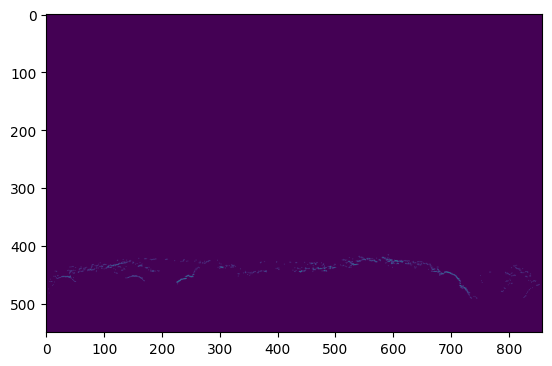

In [18]:
plt.imshow(apical_dots_1_r[10])

In [7]:
apical_dots_1 = sk.io.imread(folder_and_dome+time_dome+'_apical_dots_1.tif')

In [10]:
apical_dots_1 = apical_dots_1.astype(np.float64)
gaussian_apical_dots_1 = gaussian_filter(apical_dots_1, 20) # This is the gaussian obtained from the first iteration
gaussian_apical_dots_1 = normalize_image(gaussian_apical_dots_1)
epithelial_apical_dots_1 = gaussian_apical_dots_1*image # Epithelial from the first iteration

epithelial_apical_dots_1_r = get_image_r(epithelial_apical_dots_1) # First iteration from front
gaussian_apical_dots_1_r = get_image_r(gaussian_apical_dots_1) # First gaussian from front

In [12]:
surface_cells_mask_r = []
c = 0
total = epithelial_mask_mask_r.shape[0]



# for i in epithelial_mask_mask_r:
#     surface_cells_mask_r.append(shape_finder_2D(i))
#     c+=1
#     print(f"{c}/{total}", end='\r')
# surface_cells_mask_r = np.array(surface_cells_mask_r) # This is the 'final' dot-cell result

manager = multiprocessing.Manager()
return_dict = manager.dict()
jobs = []

for i, num in zip(epithelial_mask_mask_r, range(epithelial_mask_mask_r.shape[0])):
    p = multiprocessing.Process(target=shape_finder_2D_multiprocessing, args=(i, num, return_dict))
    jobs.append(p)
    p.start()

for proc in jobs:
    proc.join()
surface_cells_mask_r = [return_dict[idx] for idx in sorted(return_dict.keys())]






surface_cells_mask_filter_r = surface_cells_mask_r * filtered_mask_mask_r # the result multiplied by the filter

surface_cells_mask = np.transpose(surface_cells_mask_r, axes=(1,2,0))
surface_cells_mask = normalize_image(surface_cells_mask, 65535)
surface_cells_mask = surface_cells_mask.astype(np.uint16) # Raw dots without gaussian

surface_cells_mask_filter = np.transpose(surface_cells_mask_filter_r, axes=(1,2,0))
surface_cells_mask_filter = normalize_image(surface_cells_mask_filter, 65535)
surface_cells_mask_filter = surface_cells_mask_filter.astype(np.uint16) # Dots with gaussian

In [ ]:
tiff.imwrite(folder_and_dome+time_dome+'cells_mask_filter.tif', normalize_image(surface_cells_mask_filter, 65536).astype(np.uint16), imagej=True)
tiff.imwrite(folder_and_dome+time_dome+'epithelial_mask_filter.tif', normalize_image(epithelial_mask_mask, 65536).astype(np.uint16), imagej=True)

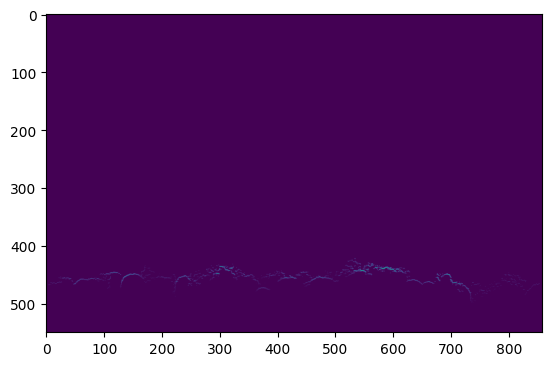

In [34]:
plt.imshow(surface_cells_mask_filter_r[0])

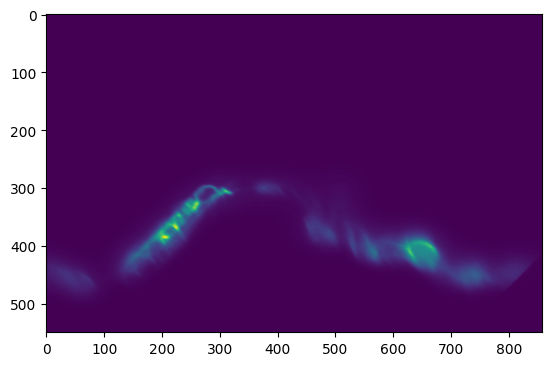

In [26]:
epithelial_mask_mask_r_r = np.transpose(epithelial_mask_mask_r, axes=(2,1,0))

plt.imshow(epithelial_mask_mask_r_r[300])

In [35]:
surface_cells_mask_r_r = []
c = 0
total = epithelial_mask_mask_r_r.shape[0]



# for i in epithelial_mask_mask_r:
#     surface_cells_mask_r.append(shape_finder_2D(i))
#     c+=1
#     print(f"{c}/{total}", end='\r')
# surface_cells_mask_r = np.array(surface_cells_mask_r) # This is the 'final' dot-cell result

manager = multiprocessing.Manager()
return_dict = manager.dict()
jobs = []

for i, num in zip(epithelial_mask_mask_r_r, range(epithelial_mask_mask_r_r.shape[0])):
    p = multiprocessing.Process(target=shape_finder_2D_multiprocessing, args=(i, num, return_dict))
    jobs.append(p)
    p.start()

for proc in jobs:
    proc.join()
surface_cells_mask_r_r = [return_dict[idx] for idx in sorted(return_dict.keys())]

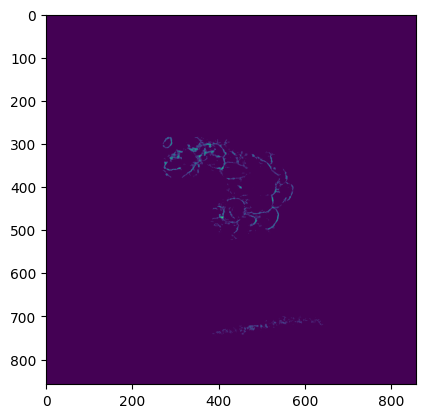

In [48]:
plt.imshow(surface_cells_mask[300])

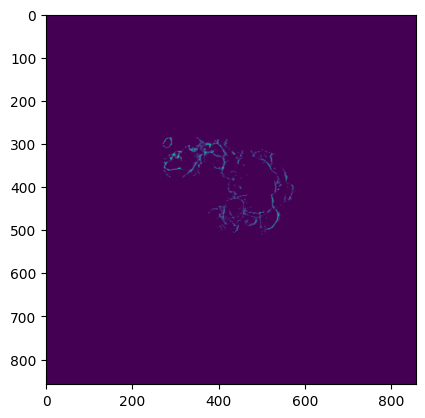

In [56]:
surface_cells_mask_r_r_r = np.transpose(surface_cells_mask_r_r, axes=(2,1,0))
surface_cells_mask_r_r_r_top = np.transpose(surface_cells_mask_r_r_r, axes=(1,2,0))
plt.imshow(surface_cells_mask_r_r_r_top[300])

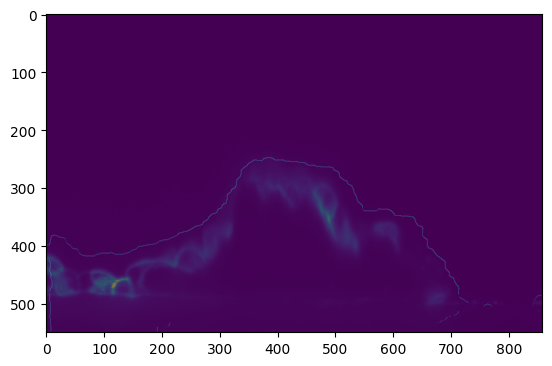

In [78]:
yyy = 480

plt.imshow(sum_mask_r[yyy])
plt.imshow(image_r[yyy], alpha=0.5)


sum_mask_r_gaussian = sum_mask_r.astype(np.float64)
sum_mask_r_gaussian = gaussian_filter(sum_mask_r_gaussian, 20)

In [44]:
surface_cells_mask_r_r_r_top = surface_cells_mask_r_r_r_top*filtered_mask_mask

In [57]:
# tiff.imwrite('./../ppujol/zmap/tp'+time_dome+'/cells_mask_filter.tif', normalize_image(surface_cells_mask_filter, 65536).astype(np.uint16), imagej=True)
# tiff.imwrite('./../ppujol/zmap/tp'+time_dome+'/epithelial_mask_filter.tif', normalize_image(epithelial_mask_mask, 65536).astype(np.uint16), imagej=True)

tiff.imwrite(folder_and_dome+time_dome+'cells_mask_filter_3.tif', normalize_image(surface_cells_mask_r_r_r_top, 65536).astype(np.uint16), imagej=True)
# tiff.imwrite('./../../../Desktop/dome70_fallingline/70_denoised_tp'+time_dome+'epithelial_mask_filter.tif', normalize_image(epithelial_mask_mask, 65536).astype(np.uint16), imagej=True)

In [54]:
surface_cells_mask_r_r_r_top = normalize_image(surface_cells_mask_r_r_r_top, 65536).astype(np.uint16)
total_dots = surface_cells_mask_filter+surface_cells_mask_r_r_r_top

In [87]:
total_dots_filtered_sum_masks = sum_mask_r_gaussian*get_image_r(total_dots)

In [88]:
tiff.imwrite(folder_and_dome+time_dome+'cells_mask_filter_total_filter_by_sum.tif', normalize_image(total_dots_filtered_sum_masks, 65536).astype(np.uint16), imagej=True)


# End of falling line

Now we should have a proper position of the cells. We can transform this onto a height map. Or we could smooth this line and then make a gaussian to multiply by the image, find the brightest point and position and then build a height map.

# Height Map

We will use the dots obtained thanks to the dot cloud

In [103]:
# surface_cells_mask_filter = sk.io.imread('./../ppujol/zmap/tp'+str(1)+'/cells_mask_filter.tif')
# time_dome = str(5)
surface_cells_mask_filter = sk.io.imread(folder_and_dome+time_dome+'epithelial_mask_filter.tif')

In [104]:
max_intensity_indices = np.argmax(surface_cells_mask_filter, axis=0)
max_intensity_indices[:4, :] = max_intensity_indices[5, :]
max_intensity_indices[-4:, :] = max_intensity_indices[-5, :]
max_intensity_values = np.max(surface_cells_mask_filter, axis=0)

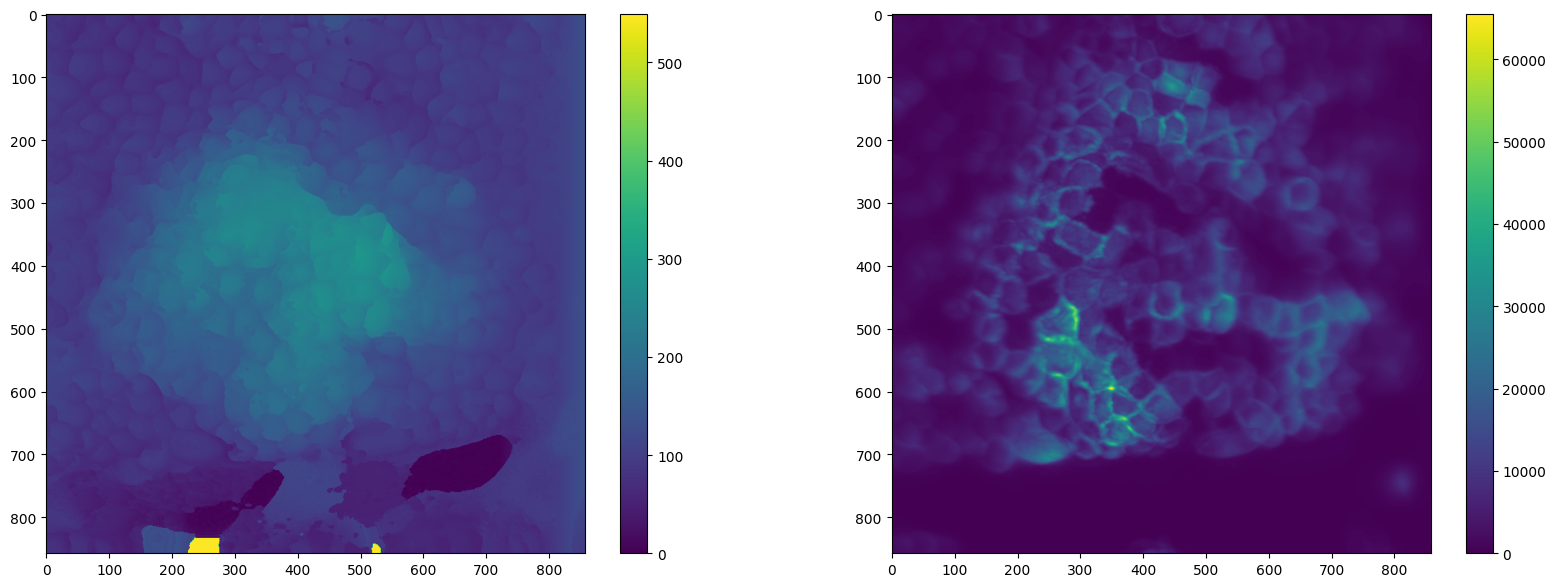

In [105]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.imshow(reverse_values(max_intensity_indices))
plt.colorbar()
plt.subplot(122)
plt.imshow(max_intensity_values)
plt.colorbar()

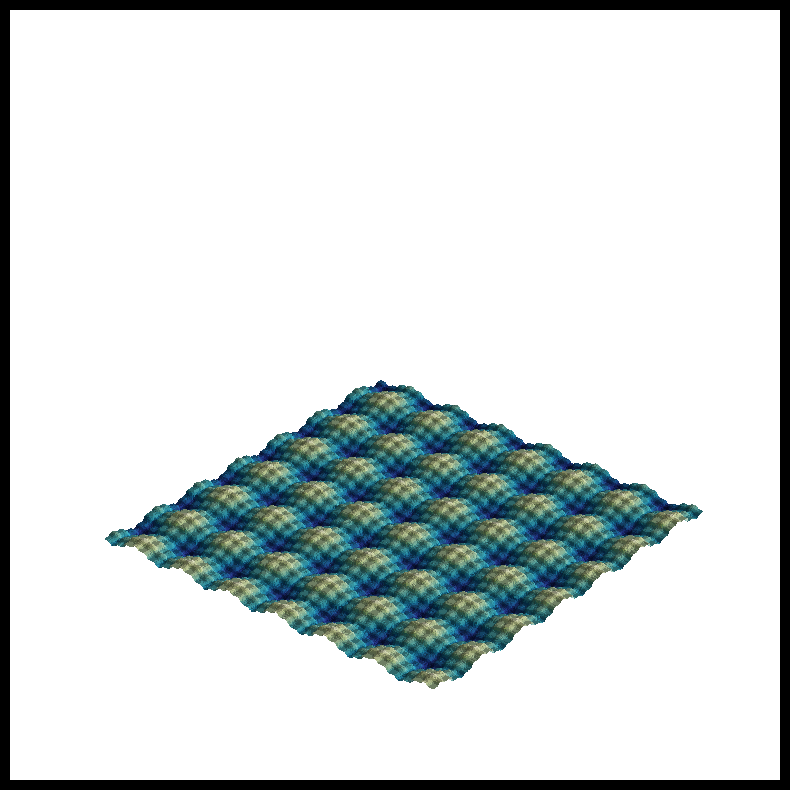

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
import scipy.ndimage as ndi
import copy
import matplotlib.colors as clr


colors = ['#ffffd9', '#edf8b1', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#253494', '#081d58']
colors.reverse()
cmap = clr.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

heightmap = copy.copy(reverse_values(max_intensity_indices))
# heightmap = heightmap[0:750, 0:750]
# heightmap = heightmap[200:700, 100:600]

# heightmap = ndi.gaussian_filter(heightmap, 1) # To smooth the map a bit
# Generate X and Y coordinates
x, y = np.meshgrid(np.arange(heightmap.shape[1]), np.arange(heightmap.shape[0]))


# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


ax.view_init(elev=30, azim=-50, roll=0)

# ax.plot_surface(-x,-y, heightmap, cmap=cmap)


ls = LightSource(azdeg=90, altdeg=30) # azimut and elevation
rgb = ls.shade(heightmap, cmap=cmap, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(y, x, heightmap, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=True)


# ls = LightSource(0, 45) # azimut and elevation
# cmap = plt.get_cmap("cividis")
# rgb = ls.shade(heightmap, cmap=cmap, vert_exag=0.1, blend_mode='soft')
# surf = ax.plot_surface(y, -x, heightmap, rstride=1, cstride=1, facecolors=rgb,
#                        linewidth=0, antialiased=False, shade=False)


ax.set_zlim(0, 650)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')





# Set the background to black
fig.patch.set_facecolor('black')

# Hide the axes
ax.set_axis_off()



# Show the plot
plt.show()
